In [54]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
from itertools import groupby
import datetime as dt
from numpy import trapz

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

## Prep animal meta data

In [2]:
path_meta = '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/VP3.csv'

data_meta = pd.read_csv(path_meta)
data_meta = pd.DataFrame(data = data_meta)

#get time diff in seconds
data_meta['start_VP'] = pd.to_datetime(data_meta['Time_VP']) - pd.to_datetime(data_meta['Time_FP']) 
data_meta['start_VP']=data_meta['start_VP']/np.timedelta64(1,'s') 

print(data_meta.shape)
data_meta.head()

(12, 6)


,Animal,Group,Time_FP,Time_VP,Depth,start_VP
0,1153,1,11:19:42,11:25:09,3.9,327.0
1,1154,1,12:01:01,12:06:35,3.9,334.0
2,1155,2,10:42:36,10:48:12,NaN,336.0
3,1157,2,12:21:03,12:26:28,4.0,325.0
4,1158,2,1:48:50,1:54:34,4.1,344.0


## Prep Med data

### Variable Definitions

- E   = event identity stamp
- T   = event time stamp

### Event Stamps ( array E )

- 5   = Pellet reinforcement delivery
- 6   = Food tray head entry
- 100 = Session termination
- 15  = ITI starts
- 16  = ITI ends

In [3]:
def get_file_info(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session, saves each accordingly
    import re
    
    task = file_path_name.split('/')[-1].split('_')[0]
    session = int(file_path_name.split('/')[-1].split('_')[1])
    animal = int(file_path_name.split('/')[-1].split('_')[2])
    date = file_path_name.split('/')[-1].split('_')[3]

    return task, session, animal, date

In [4]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [5]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        if re.search(str(event_letter + ':'), str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
        if re.search(str(time_letter + ':'), str(array[i])):
            i = i + 1
            try:
                while re.search('\[\'\ \ ', str(array[i])):
                    split = array[i][0].split()[1:]
                    for element in split:
                        time_data.append(float(element))
                    i = i + 1
            except:
                pass
        i = i + 1
    
    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [6]:
def get_trial_times_VP(events_and_times, ITI_end, session_end):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for pellet deliveries and end of trial segment
    #finds time_stamps for each start and end, puts into new dataframe

    ITI_end = list(events_and_times[events_and_times['event_stamp'] == ITI_end]['time_stamp'].values)
    session_end = list(events_and_times[events_and_times['event_stamp'] == session_end]['time_stamp'].values)
    
    start_times = ITI_end
    end_times = np.append(ITI_end[1:], session_end)

    times = pd.DataFrame(data = [start_times, end_times])
    times = times.T
    times.columns = ['trial_start', 'trial_end']
    
    return times

In [7]:
def create_trial_df(events_and_times, trial_times):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    while i < len(trial_times):
        data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i] - .01)]
        data['trial_#'] = [i]*len(data)
        data['trial_start'] = trial_times['trial_start'][i]
        data['trial_end'] = trial_times['trial_end'][i]
        trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
        i = i + 1
    
    return trial_data

In [8]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [9]:
def latency(trial_data, event_num):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_ave = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
        else:
            latency_1st.append((data['time_stamp'] - data['trial_start']).values[0])
        i = i + 1
    
    return latency_1st

In [10]:
def create_session_df(trial_data, event_dic):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
    times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')] = latency(trial_data, event)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    session_data['trial_start'] = trial_data.groupby('trial_#')['trial_start'].first()
    session_data['first_pellet'] = trial_data[trial_data['event_stamp'] == 5.0].groupby('trial_#')['time_stamp'].first()
    session_data['first_HE'] = trial_data[trial_data['event_stamp'] == 6.0].groupby('trial_#')['time_stamp'].first()
    
    return session_data

### Get med file paths

In [11]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test'

file_names = os.listdir(path)
print(len(file_names))

file_paths = []

for file in file_names:
    
    file_path = path + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0]

12
12


'/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1166_210212'

### Process Med data

In [12]:
%%time
final_data = pd.DataFrame()

bit_dic = {'HE': 6, 'pellet': 5}

for file in file_paths:

    print(file) 
    
    #proccess file
    task, session, animal, date = get_file_info(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "E", "T")
    trial_times = get_trial_times_VP(events_and_times, 16, 100)
    trial_data = create_trial_df(events_and_times, trial_times)
    session_data = create_session_df(trial_data, bit_dic)
   
    #create pandas tidy df for within session
    session_data['task'] = [task]*(session_data.shape[0])    
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['Animal'] = [animal]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['Group'] = int(data_meta[data_meta['Animal'] == int(animal)]['Group'])
   
    session_data = session_data[['task', 'date', 'session', 'Animal', 'Group', 'trial_num', 
                                 'trial_duration', 'trial_start', 'first_pellet', 'first_HE',
                                 'HE_count', 'HE_latency_1st', 'pellet_count']]
    
    #add to final data frame
    final_data = pd.concat([final_data, session_data], axis = 0, ignore_index=True)

final_data.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1166_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1154_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1158_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1162_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1160_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1153_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1165_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1163_210212
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/variable_pellet/test/VP_3_1155_210212
/Users/abbieschindler/Docume

,task,date,session,Animal,Group,trial_num,trial_duration,trial_start,first_pellet,first_HE,HE_count,HE_latency_1st,pellet_count
0,VP,210212,3,1166,2,0,30.2,89.99,90.0,114.28,2,24.29,1
1,VP,210212,3,1166,2,1,60.9,120.19,120.2,126.29,11,6.10,2
2,VP,210212,3,1166,2,2,32.3,181.09,181.1,191.52,4,10.43,4
3,VP,210212,3,1166,2,3,62.3,213.39,213.4,216.10,12,2.71,4
4,VP,210212,3,1166,2,4,90.9,275.69,275.7,281.54,9,5.85,2


### Merge with meta data and adjust times based on info in meta data

In [13]:
data_final = final_data.merge(data_meta, on=['Animal', 'Group'])
data_final['trial_start'] = data_final['trial_start'] + data_final['start_VP'] -1
data_final['first_pellet'] = data_final['first_pellet'] + data_final['start_VP'] -1
data_final['first_HE'] = data_final['first_HE'] + data_final['start_VP'] -1

#drop final trial (no pellet delivered)
data_final = data_final[data_final['trial_num'] != 9]
print(data_final.shape)
data_final.head()

(108, 17)


,task,date,session,Animal,Group,trial_num,trial_duration,trial_start,first_pellet,first_HE,HE_count,HE_latency_1st,pellet_count,Time_FP,Time_VP,Depth,start_VP
0,VP,210212,3,1166,2,0,30.2,428.99,429.0,453.28,2,24.29,1,2:25:10,2:30:50,3.9,340.0
1,VP,210212,3,1166,2,1,60.9,459.19,459.2,465.29,11,6.10,2,2:25:10,2:30:50,3.9,340.0
2,VP,210212,3,1166,2,2,32.3,520.09,520.1,530.52,4,10.43,4,2:25:10,2:30:50,3.9,340.0
3,VP,210212,3,1166,2,3,62.3,552.39,552.4,555.10,12,2.71,4,2:25:10,2:30:50,3.9,340.0
4,VP,210212,3,1166,2,4,90.9,614.69,614.7,620.54,9,5.85,2,2:25:10,2:30:50,3.9,340.0


In [14]:
data_final_mean = data_final.groupby(['task', 'date', 'session', 'pellet_count', 'Animal', 'Group',]).mean().reset_index()

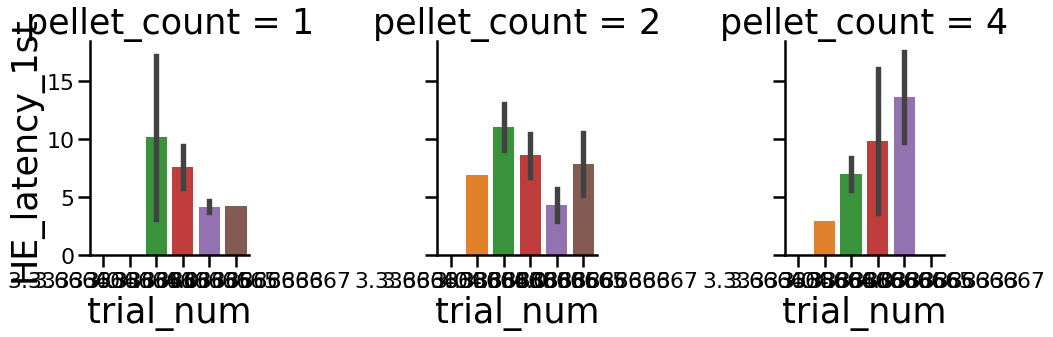

In [15]:
sns.catplot(x='trial_num', y='HE_latency_1st', data=data_final_mean, ci=68, kind='bar', col='pellet_count')

In [16]:
data_final_long = pd.melt(data_final, id_vars=['task', 'date', 'session', 'Animal', 'Group', 'trial_num', 'trial_duration',
                            'HE_count', 'HE_latency_1st', 'pellet_count'], 
        value_vars=['trial_start', 'first_pellet', 'first_HE',],
        var_name='event', value_name='time')

print(data_final_long.shape)
data_final_long.head()

(324, 12)


,task,date,session,Animal,Group,trial_num,trial_duration,HE_count,HE_latency_1st,pellet_count,event,time
0,VP,210212,3,1166,2,0,30.2,2,24.29,1,trial_start,428.99
1,VP,210212,3,1166,2,1,60.9,11,6.10,2,trial_start,459.19
2,VP,210212,3,1166,2,2,32.3,4,10.43,4,trial_start,520.09
3,VP,210212,3,1166,2,3,62.3,12,2.71,4,trial_start,552.39
4,VP,210212,3,1166,2,4,90.9,9,5.85,2,trial_start,614.69


## Prep FP data

### Get FP file paths

In [17]:
#create list of dir paths

orig_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212'

dir_path_list = os.listdir(orig_path)

data_dir_paths = []
for directory in dir_path_list:
    int_path = orig_path + '/' + directory
    data_dir_paths.append(int_path)
    
data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1166_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1159_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1158_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1165_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1153_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1161_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1157_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1160_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1154_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1162_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1163_VP2.txt',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1155_VP

### Process FP data

In [18]:
def create_FP_df(path):
        
    animal = int(path.split('/')[-1].split('_')[0])
    task = path.split('/')[-1].split('_')[1].split('.')[0]
    
    data_int = pd.read_table(path, sep='\t', header=None)
    data_int = pd.DataFrame(data = data_int)
    data_int.columns = ['time', 'signal', 'current', 'signal_raw', 'trash']
    #add animal
    data_int['Animal'] = animal
    #add group
    data_int['group'] = data_meta[data_meta['Animal'] == data_int['Animal'].unique()[0]]['Group'].values[0]
    #add task
    data_int['task'] = task
    
    return data_int
        

In [19]:
FP_df = pd.DataFrame()

for path in data_dir_paths:
    print(path)
    
    data_int = create_FP_df(path)

    if FP_df.shape[0] == 0:
        FP_df = data_int
    else:
        FP_df = pd.concat([FP_df, data_int], axis=0)
        
print(FP_df.shape)
FP_df.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1166_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1159_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1158_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1165_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1153_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1161_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1157_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1160_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1154_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1162_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1163_VP2.txt
/Users/abbieschindler/Documents/Schindler_Lab/Data/FP/trial/210212/1155_VP2.txt
(1176683, 8)


,time,signal,current,signal_raw,trash,Animal,group,task
0,0.00,32768,2.45846,15112.72266,0.0,1166,2,VP2
1,0.01,32768,2.45846,17901.40430,0.0,1166,2,VP2
2,0.02,32768,2.45846,20649.65430,0.0,1166,2,VP2
3,0.03,32768,2.45358,23277.79492,0.0,1166,2,VP2
4,0.04,32768,2.45358,25712.37109,0.0,1166,2,VP2


## Combine data streams

In [20]:
data_final_long.head()

,task,date,session,Animal,Group,trial_num,trial_duration,HE_count,HE_latency_1st,pellet_count,event,time
0,VP,210212,3,1166,2,0,30.2,2,24.29,1,trial_start,428.99
1,VP,210212,3,1166,2,1,60.9,11,6.10,2,trial_start,459.19
2,VP,210212,3,1166,2,2,32.3,4,10.43,4,trial_start,520.09
3,VP,210212,3,1166,2,3,62.3,12,2.71,4,trial_start,552.39
4,VP,210212,3,1166,2,4,90.9,9,5.85,2,trial_start,614.69


In [21]:
data_comb = FP_df.merge(data_final_long, on=['Animal', 'time'], how='left')
print(data_comb.shape)
data_comb.tail()

(1176683, 18)


,time,signal,current,signal_raw,trash,Animal,group,task_x,task_y,date,session,Group,trial_num,trial_duration,HE_count,HE_latency_1st,pellet_count,event
1176678,907.90,32575,2.34605,0.0,0.0,1155,2,VP2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176679,907.91,32576,2.34116,0.0,0.0,1155,2,VP2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176680,907.92,32577,2.33627,0.0,0.0,1155,2,VP2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176681,907.93,32582,2.34605,0.0,0.0,1155,2,VP2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1176682,907.94,32577,2.33627,0.0,0.0,1155,2,VP2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Get perievent

In [193]:
def peri_event(df, time, total_time, baseline_time):
    
    #time = time when event happens
    #total_time = total length of peri event
    #baseline_time = baseline duration (assumed that this should be taken from immediately prior to the event)
    
    start_time = time - baseline_time
    end_time = start_time + total_time

    #get peri event signal
    data_int = df[(df['time'] >= start_time) & (df['time'] <= (end_time))]
    data_int['event_time'] = data_int.reset_index().index / 100
    
    #get baseline signal and compute median and MAD
    baseline_signal = df[(df['time'] >= start_time) & (df['time'] < (time-1))]['signal']
    #f_med = baseline_signal.median()
    #f_mad = baseline_signal.mad()
    f_mean = baseline_signal.mean()
    f_sd = baseline_signal.std()
    
    #compute robust z score 
    #data_int['sig_z'] = (data_int['signal'] - f_med) / (f_mad)
    #compute normal z score
    data_int['sig_z'] = (data_int['signal'] - f_mean) / (f_sd)
    
    return data_int

In [195]:
def robustz_df(df, event):
    
    times = df[(~df['event'].isna()) & (df['event']==event)]['time'].values
    
    data_final_int = pd.DataFrame()
    i=0
    for time in times:
        data_int = peri_event(df, time, 30, 20)
        data_int['pellet'] = int(df[df['time'] == time]['pellet_count'])
        data_int['Group'] = int(df[df['time'] == time]['Group'])
        data_int['trial'] = i
        i+=1
    
        if data_final_int.shape[0] == 0:
            data_final_int = data_int
        else:
            data_final_int = pd.concat([data_final_int, data_int], axis=0)

    return data_final_int

In [196]:
perievent_df = pd.DataFrame()

for animal in data_comb['Animal'].unique():
    print(animal)
    df_int = data_comb[data_comb['Animal'] == animal]
    data_final_int = robustz_df(df_int, 'first_pellet')
    
    if perievent_df.shape[0] == 0:
        perievent_df = data_final_int
    else:
        perievent_df = pd.concat([perievent_df, data_final_int], axis=0)
        
    print(perievent_df.shape)
    
perievent_df.head()

1166
(27009, 22)
1159
(53975, 22)
1158
(80983, 22)
1165
(107992, 22)
1153
(135001, 22)
1161
(162010, 22)
1157
(189019, 22)
1160
(213026, 22)
1154
(240034, 22)
1162
(267043, 22)
1163
(294052, 22)
1155
(321061, 22)


,time,signal,current,signal_raw,trash,Animal,group,task_x,task_y,date,session,Group,trial_num,trial_duration,HE_count,HE_latency_1st,pellet_count,event,event_time,sig_z,pellet,trial
40900,409.00,33431,2.33627,33426.66406,0.0,1166,2,VP2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.307820,1,0
40901,409.01,33436,2.33139,33428.72266,0.0,1166,2,VP2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.01,0.351429,1,0
40902,409.02,33441,2.33627,33430.68359,0.0,1166,2,VP2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.395039,1,0
40903,409.03,33440,2.33627,33432.51562,0.0,1166,2,VP2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.386317,1,0
40904,409.04,33435,2.33627,33434.20703,0.0,1166,2,VP2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,0.04,0.342707,1,0


In [197]:
perievent_df['Group'] = perievent_df['Group'].replace({1:'Sham 3x', 2:'Blast 3x'})

1166


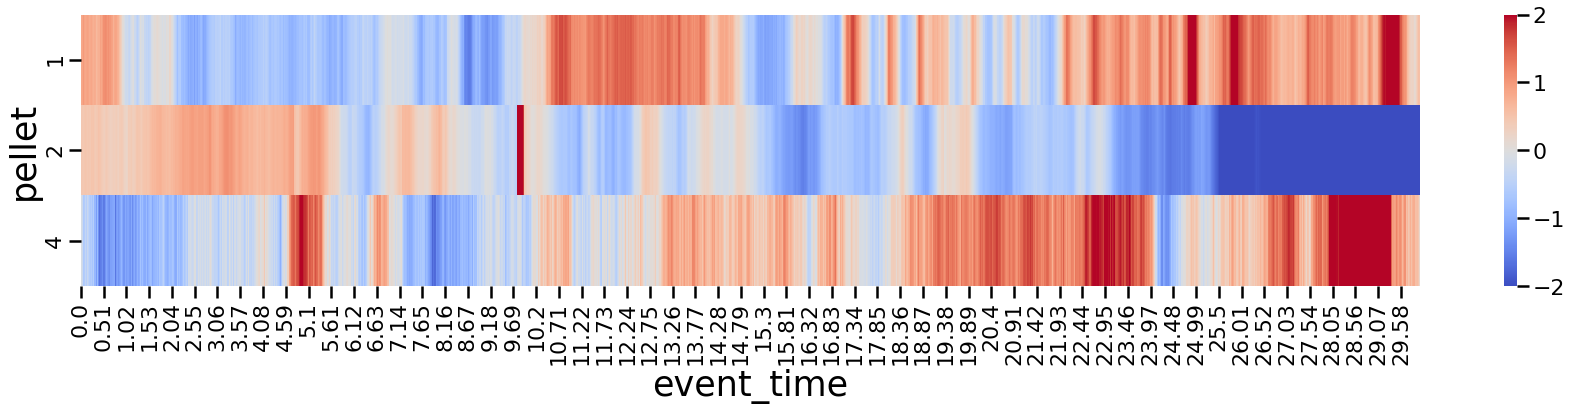

1159


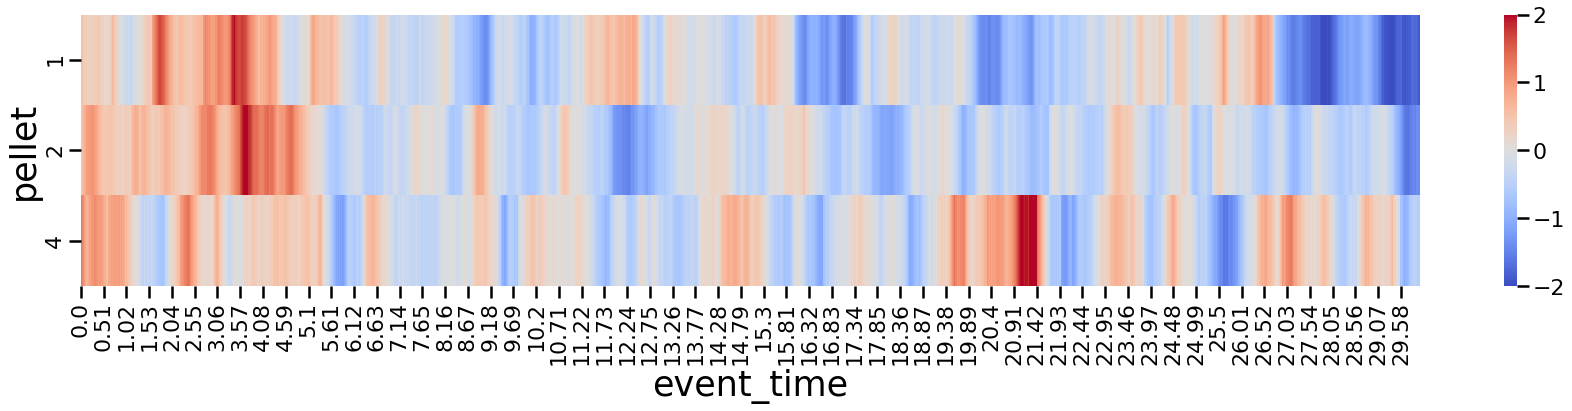

1158


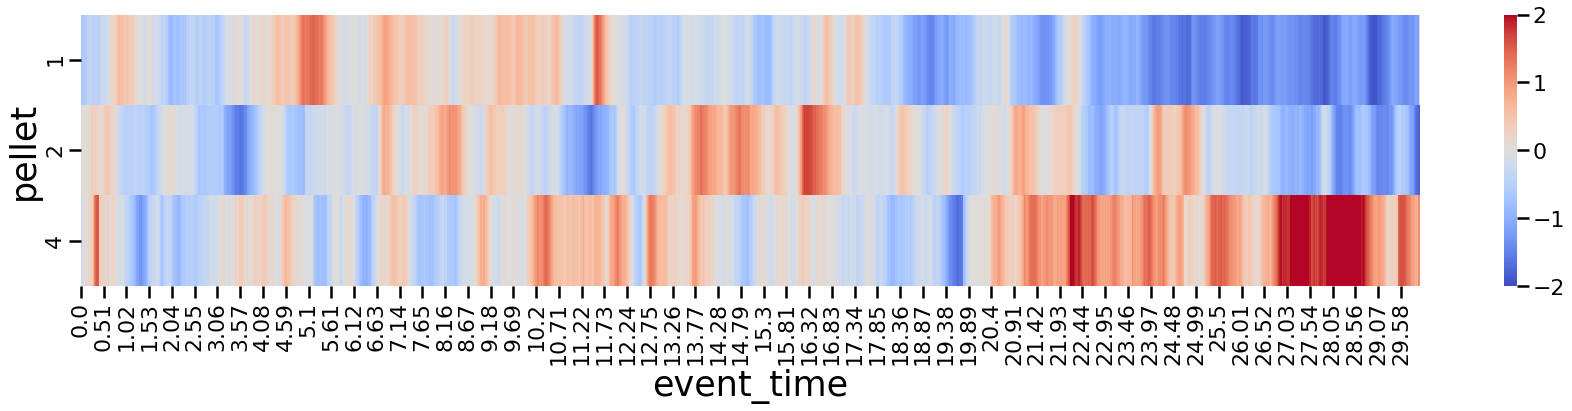

1165


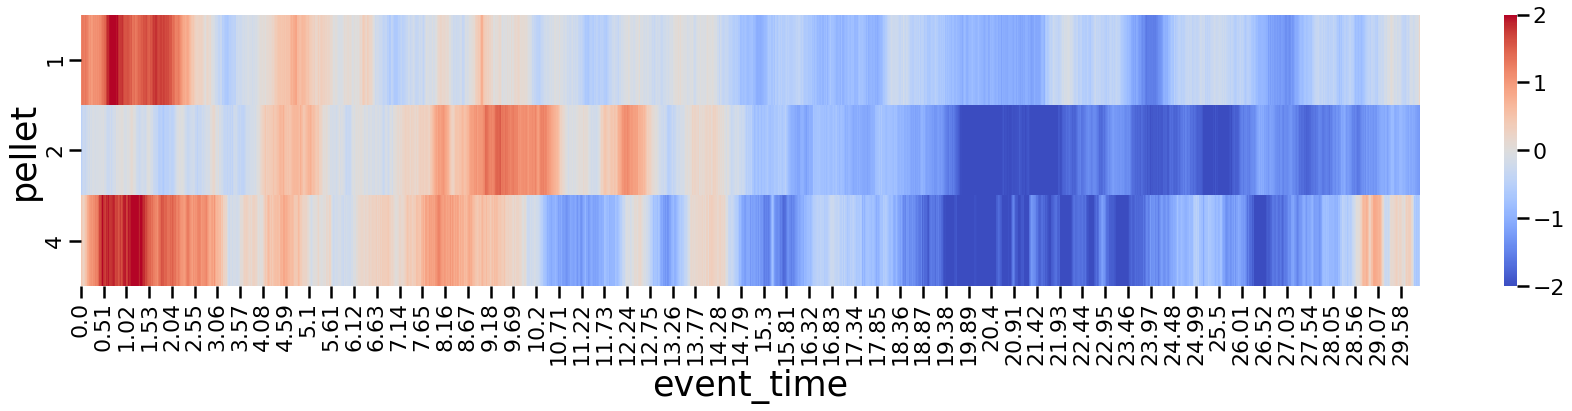

1153


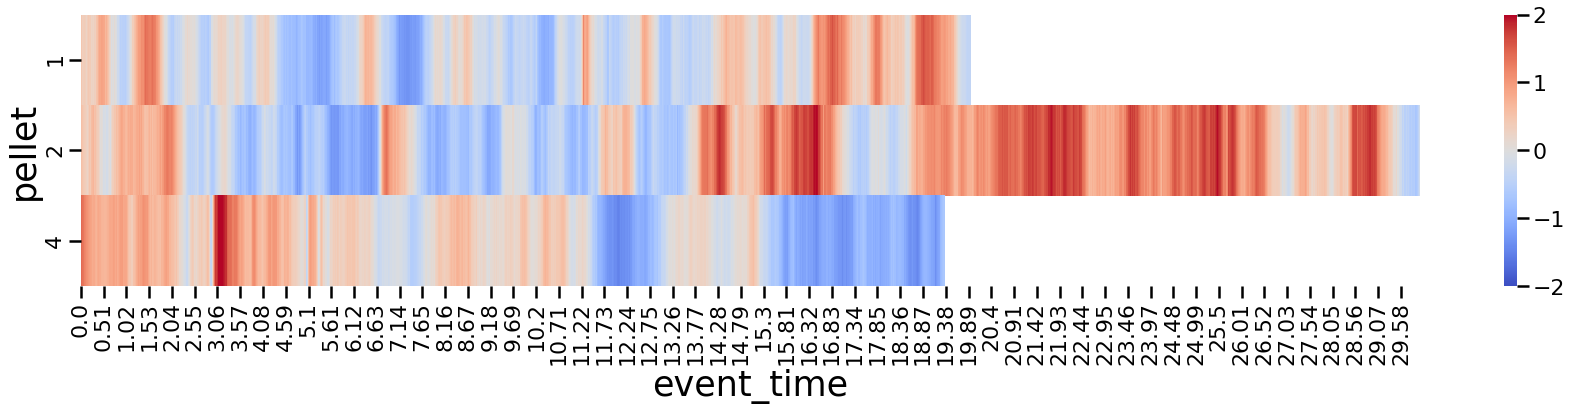

1161


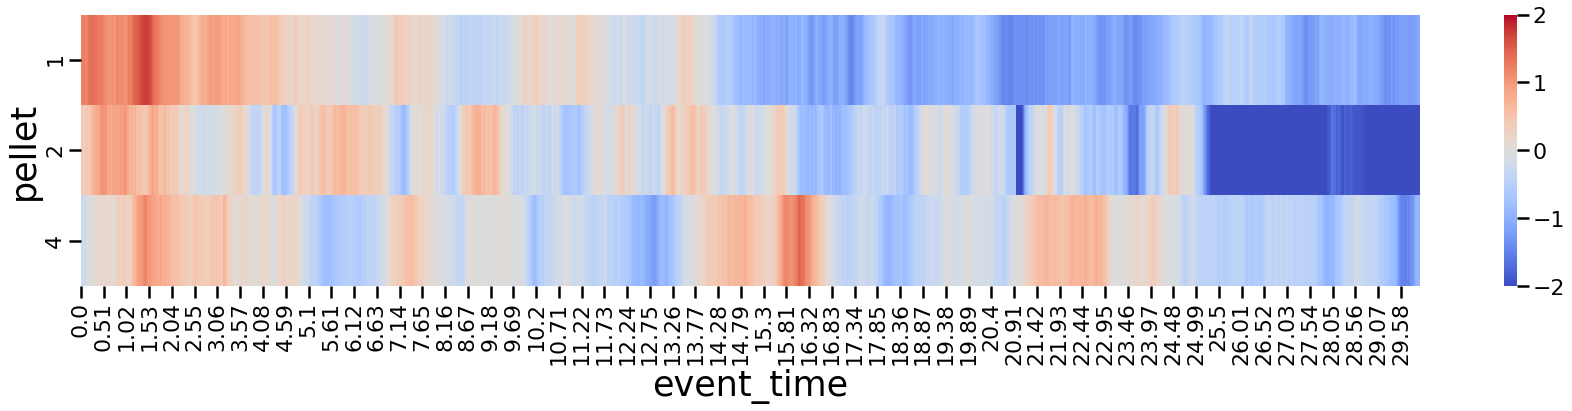

1157


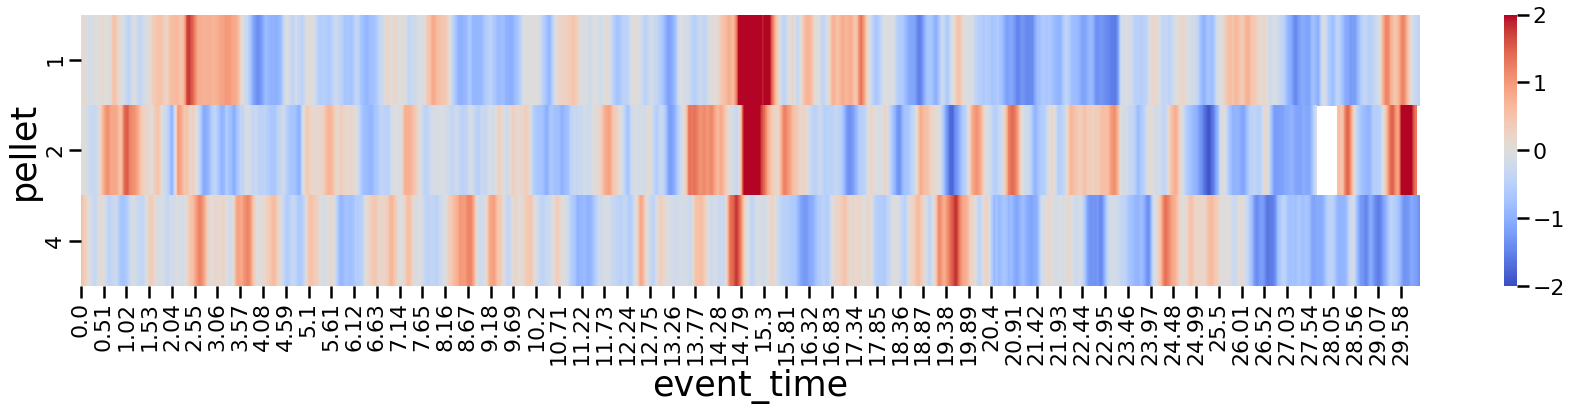

1160


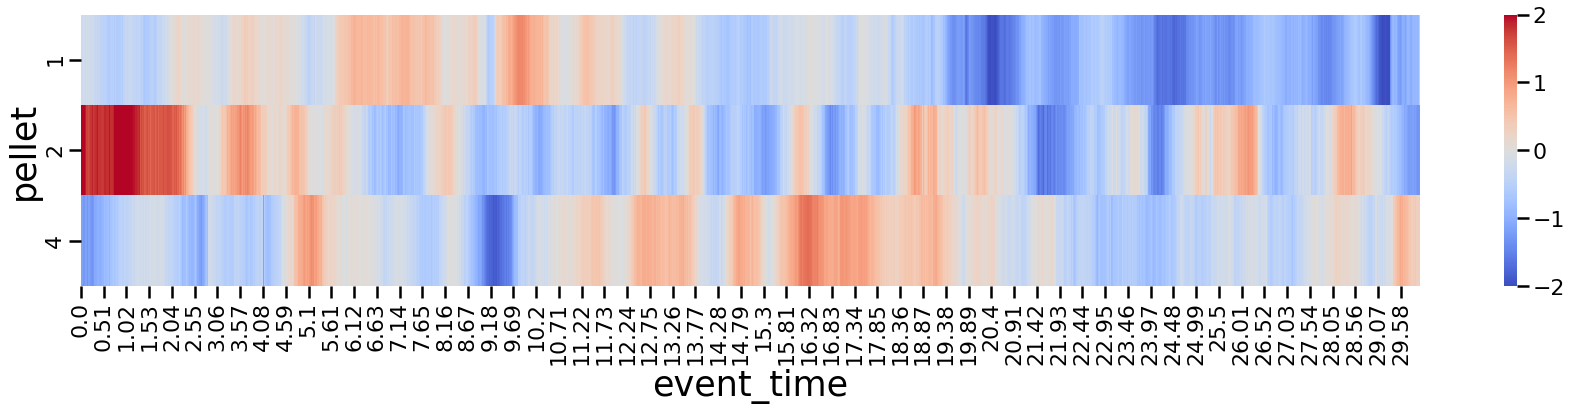

1154


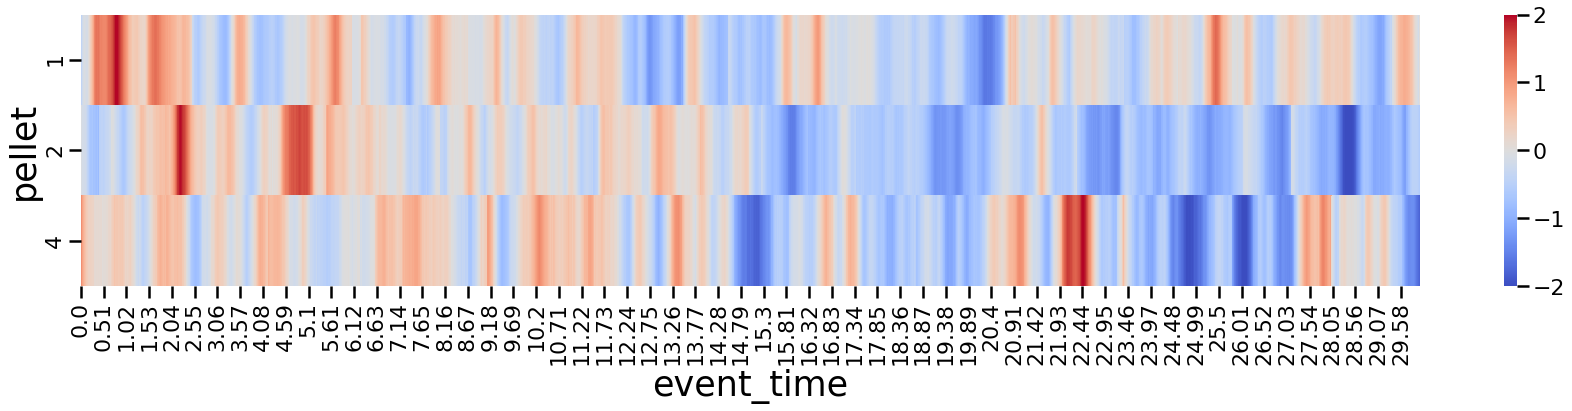

1162


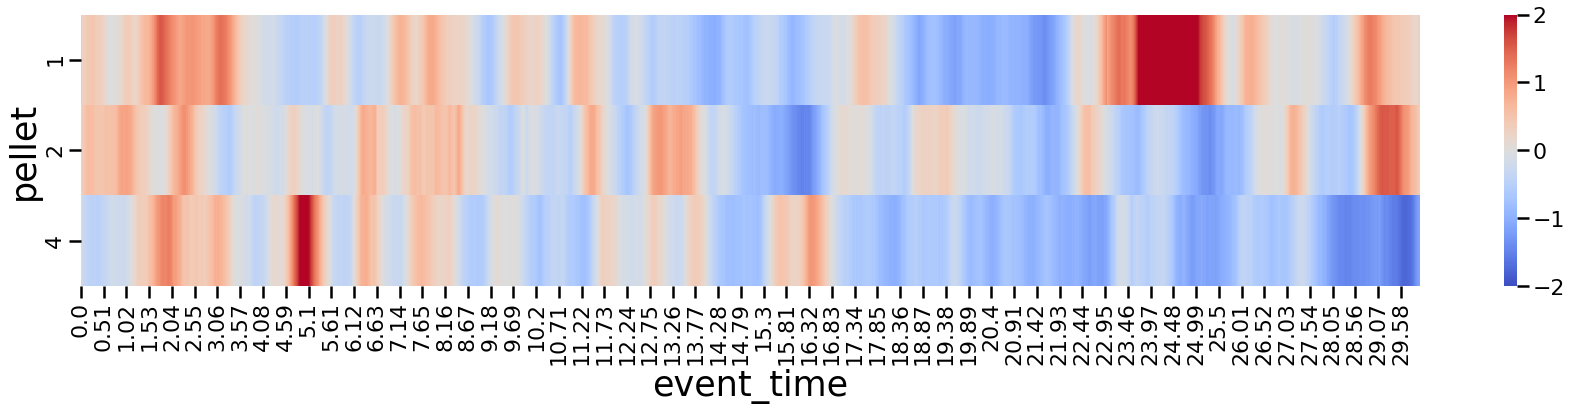

1163


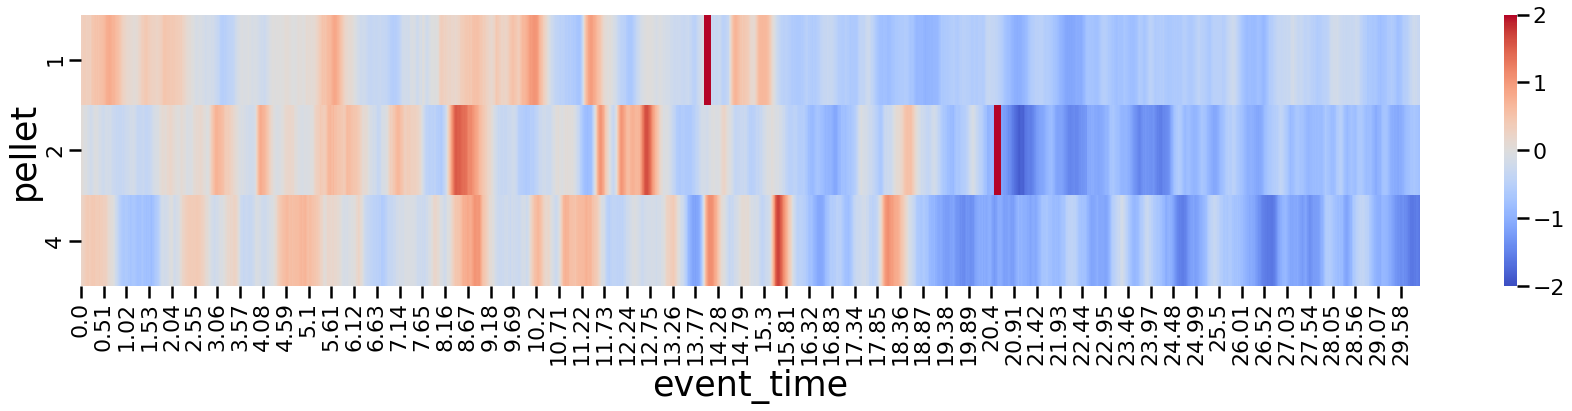

1155


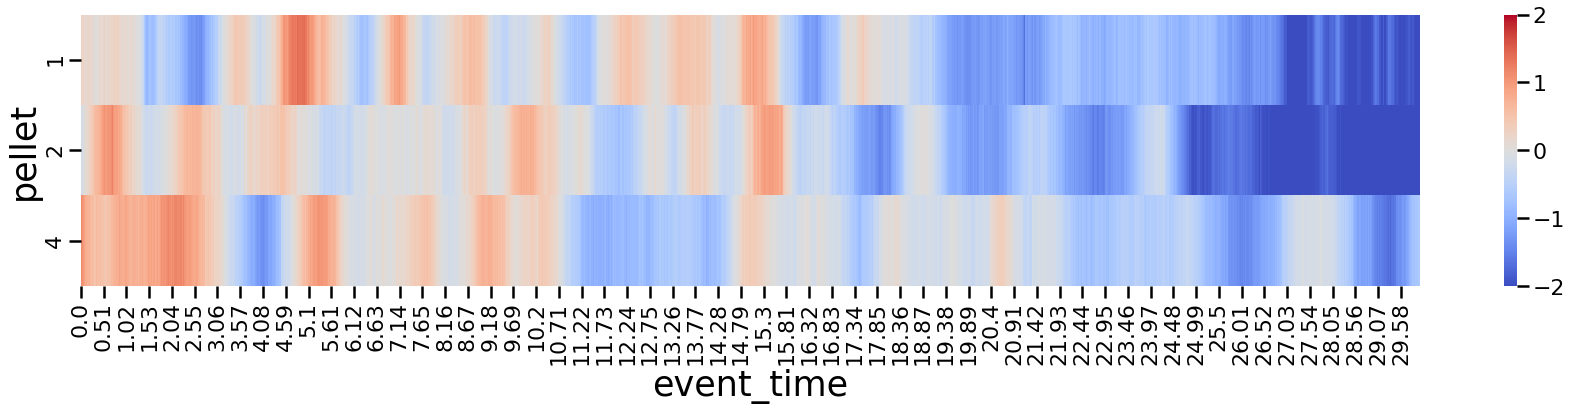

In [198]:
for animal in perievent_df['Animal'].unique():
    print(animal)
    #plt.figure(figsize=(15,15))
    df_int = perievent_df[perievent_df['Animal'] == animal]
    groupby = df_int.groupby(['pellet', 'event_time'])['sig_z'].mean().reset_index()
    groupby = groupby.pivot('pellet', 'event_time', "sig_z")
    plt.figure(figsize=(30,5))
    ax = sns.heatmap(groupby, cmap="coolwarm", vmin=-2, vmax=2)
    plt.show()
    #sns.lineplot(x='event_time', y='sig_z', data=df_int, ci=68, hue='pellet')
    #plt.show()

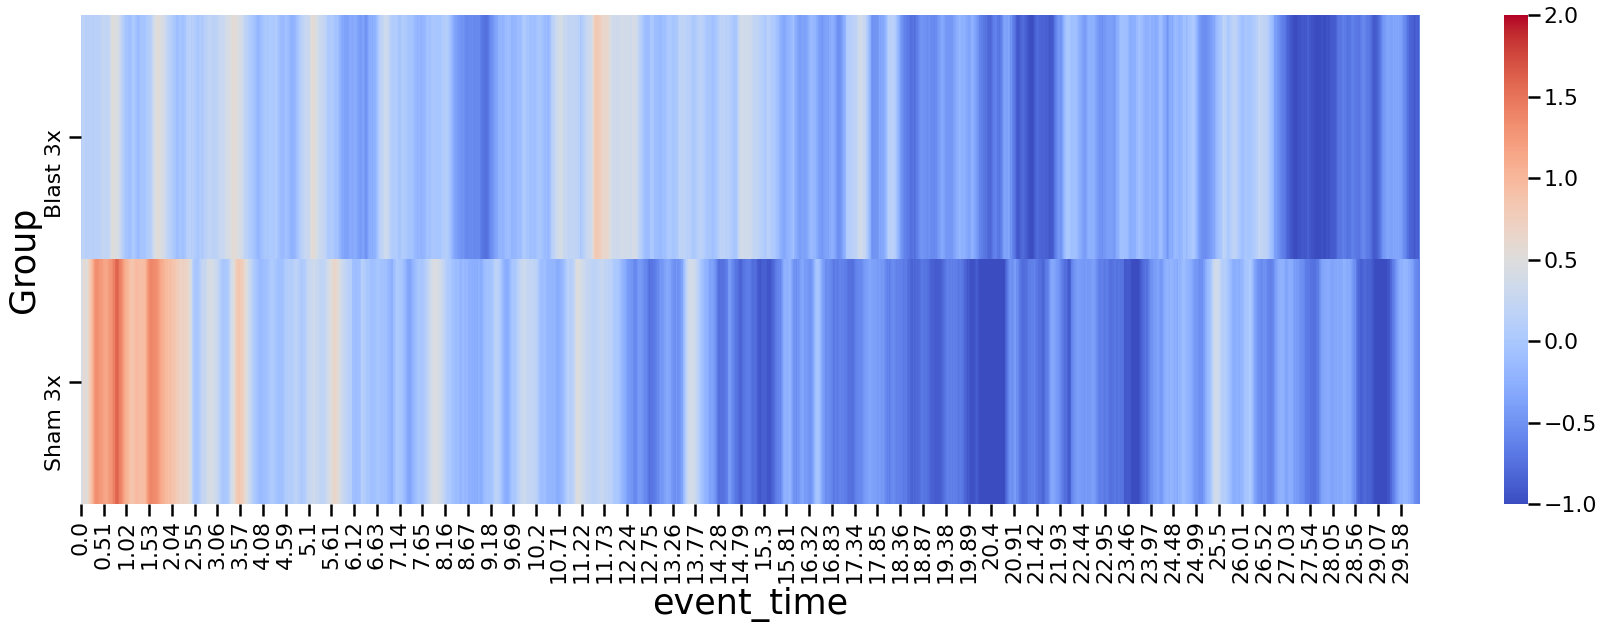

In [214]:
d = perievent_df[perievent_df['pellet'] ==1]
#d = perievent_df
d=d[d['Animal'].isin(animals_keep)]
#d = d[d['group'] == 2]
groupby = d.groupby(['Group', 'event_time'])['sig_z'].mean().reset_index()
#viz
groupby = groupby.pivot('Group', 'event_time', "sig_z")
plt.figure(figsize=(30,9))
ax = sns.heatmap(groupby, cmap="coolwarm", vmin=-1, vmax=2)
plt.show()

In [51]:
perievent_df.head()

,time,signal,current,signal_raw,trash,Animal,group,task_x,task_y,date,session,Group,trial_num,trial_duration,HE_count,HE_latency_1st,pellet_count,event,event_time,sig_z,pellet
42400,424.00,33296,2.36071,33296.26953,0.0,1166,2,VP2,NaN,NaN,NaN,Blast 3x,NaN,NaN,NaN,NaN,NaN,NaN,0.00,-1.529031,1
42401,424.01,33298,2.36560,33294.48047,0.0,1166,2,VP2,NaN,NaN,NaN,Blast 3x,NaN,NaN,NaN,NaN,NaN,NaN,0.01,-1.501527,1
42402,424.02,33299,2.36560,33292.96484,0.0,1166,2,VP2,NaN,NaN,NaN,Blast 3x,NaN,NaN,NaN,NaN,NaN,NaN,0.02,-1.487776,1
42403,424.03,33293,2.36560,33291.62500,0.0,1166,2,VP2,NaN,NaN,NaN,Blast 3x,NaN,NaN,NaN,NaN,NaN,NaN,0.03,-1.570287,1
42404,424.04,33296,2.36560,33290.38672,0.0,1166,2,VP2,NaN,NaN,NaN,Blast 3x,NaN,NaN,NaN,NaN,NaN,NaN,0.04,-1.529031,1


In [50]:
perievent_df.columns.values

array(['time', 'signal', 'current', 'signal_raw', 'trash', 'Animal',
       'group', 'task_x', 'task_y', 'date', 'session', 'Group',
       'trial_num', 'trial_duration', 'HE_count', 'HE_latency_1st',
       'pellet_count', 'event', 'event_time', 'sig_z', 'pellet'],
      dtype=object)

<AxesSubplot:xlabel='event_time', ylabel='sig_z'>

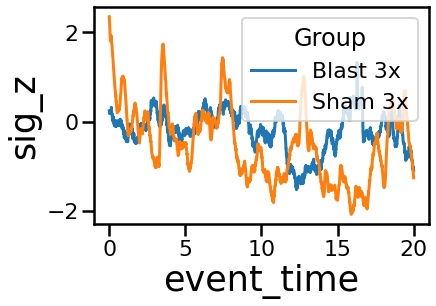

In [128]:
d = perievent_df[perievent_df['pellet'] ==4]


d=d[d['Animal'].isin(animals_exclude)]
groupby = d.groupby(['Group', 'Animal', 'event_time'])['sig_z'].mean().reset_index()
sns.lineplot(x='event_time', y='sig_z', data=groupby, ci=None, hue='Group')

<AxesSubplot:xlabel='event_time', ylabel='sig_z'>

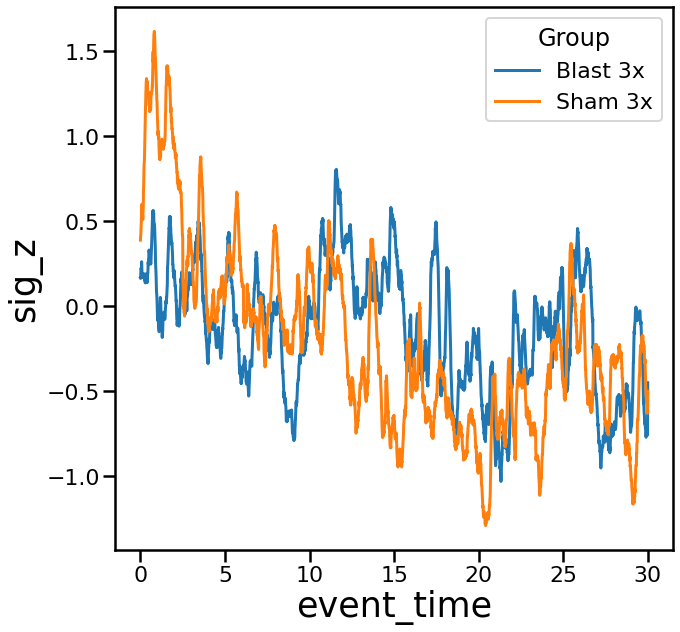

In [212]:
d = perievent_df[perievent_df['pellet'] ==1]

#animals_keep = [1158, 1159, 1161, 1162, 1166]

d1=d[d['Animal'].isin(animals_keep)]
animals_keep = [1154, 1157, 1158, 1159, 1161, 1166]

d=d[d['Animal'].isin(animals_keep)]
plt.figure(figsize=(10,10))
groupby = d.groupby(['Group', 'Animal', 'event_time'])['sig_z'].mean().reset_index()
sns.lineplot(x='event_time', y='sig_z', data=groupby, ci=None, hue='Group')

In [206]:
start_time = 20
end_time = 25

data_final_AUC = pd.DataFrame()
for Animal in data_final['Animal'].unique():
    print(Animal)
    d=perievent_df[perievent_df['Animal']==Animal]
    
    for trial in d['trial'].unique():
        print(trial)
    
        d_short = d[(d['event_time']>=start_time) & (d['event_time']<end_time)]
        d_trial_short = d_short[d_short['trial']==trial]
   
        area = trapz(d_trial_short['event_time'],d_trial_short['sig_z'])
        d_gp = d_trial_short.groupby(['Animal', 'Group', 'trial', 'pellet'])['sig_z'].max().reset_index(name='max')
        d_gp['AUC'] = area

        if data_final_AUC.shape[0] == 0:
            data_final_AUC = d_gp
        else:
            data_final_AUC = pd.concat([data_final_AUC, d_gp], axis=0) 
data_final_AUC.head()

1166
0
1
2
3
4
5
6
7
8
1154
0
1
2
3
4
5
6
7
8
1158
0
1
2
3
4
5
6
7
8
1162
0
1
2
3
4
5
6
7
8
1160
0
1
2
3
4
5
6
7
1153
0
1
2
3
4
5
6
7
8
1165
0
1
2
3
4
5
6
7
8
1163
0
1
2
3
4
5
6
7
8
1155
0
1
2
3
4
5
6
7
8
1159
0
1
2
3
4
5
6
7
8
1161
0
1
2
3
4
5
6
7
8
1157
0
1
2
3
4
5
6
7
8


,Animal,Group,trial,pellet,max,AUC
0,1166,Blast 3x,0,1,3.395379,54.597433
0,1166,Blast 3x,1,2,1.740385,-121.668269
0,1166,Blast 3x,2,4,2.258673,-0.985254
0,1166,Blast 3x,3,4,3.076747,-32.068935
0,1166,Blast 3x,4,2,1.207230,59.500220


In [207]:
data_final_AUC_gb = data_final_AUC.groupby(['Animal', 'Group', 'pellet'])['max'].mean().reset_index()
data_final_AUC_gb.set_index(['Animal', 'Group', 'pellet']).unstack(-1).reset_index().sort_values(['Group']).to_csv('wireless_pellet_drop.csv')

In [208]:
data_final_AUC_gb

,Animal,Group,pellet,max
0,1153,Sham 3x,1,inf
1,1153,Sham 3x,2,3.120982
2,1153,Sham 3x,4,inf
3,1154,Sham 3x,1,1.711577
4,1154,Sham 3x,2,1.472272
5,1154,Sham 3x,4,3.004126
6,1155,Blast 3x,1,0.414072
7,1155,Blast 3x,2,0.397789
8,1155,Blast 3x,4,0.950572
9,1157,Blast 3x,1,0.750463


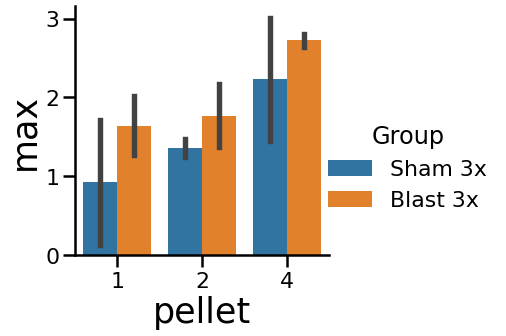

In [211]:
animals_keep = [1154, 1157, 1158, 1159, 1161, 1166]
d=data_final_AUC.groupby(['Animal', 'Group', 'pellet']).mean().reset_index()
d1=d[d['Animal'].isin(animals_keep)]

sns.catplot(x='pellet', y='max', data=d1, ci=68, hue='Group', kind='bar')

In [166]:
d1

,Animal,Group,pellet,trial,max,AUC
3,1154,Sham 3x,1,4.333333,1.711577,15.829406
4,1154,Sham 3x,2,4.666667,1.472272,-5.881764
5,1154,Sham 3x,4,3.000000,3.004126,-30.233368
12,1158,Blast 3x,1,4.666667,1.251267,-14.445838
13,1158,Blast 3x,2,3.666667,2.431334,23.054814
14,1158,Blast 3x,4,3.666667,2.989840,-1.376814
15,1159,Blast 3x,1,3.666667,1.811999,8.291839
16,1159,Blast 3x,2,4.000000,1.433814,-1.594109
17,1159,Blast 3x,4,4.333333,2.739699,-12.555310
33,1166,Blast 3x,1,4.000000,2.745028,30.730626


In [ ]:
plt.figure(figsize=(15,15))
data=perievent_df[perievent_df['Animal'] != 1155]
data=data[data['Animal'] != 1154]
sns.lineplot(x='event_time', y='sig_z', data=data, ci=68, hue='Group', size='pellet')

In [ ]:
file_path = file_paths[11]
print('file_path:', '\n', file_path, '\n')

task, session, animal, date = get_file_info(file_path)
print('task:', task, 'date:', date, 'animal:', animal, 'session:', session, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, "E", "T")
print(events_and_times.head(), '\n')

trial_times = get_trial_times_VP(events_and_times, 16, 100)
print(trial_times.head(), '\n')

trial_data = create_trial_df(events_and_times, trial_times)
print(trial_data.head(), '\n')

bit_dic = {'HE': 6, 'pellet': 5}
session_data = create_session_df(trial_data, bit_dic)
session_data